# Projet classification de données hyperspectrales

Les images hyperspectrales sont un type de données que nous avez déjà étudiées et traitées dans un des tout premier TP. Une image hyperspectrale correspond à une image dont le contenu spectral (aka. le nombre de couleurs) est enrichi par rapport aux images RGB acquises par exemple avec vos téléphonnes portable. 


L'objectif de ce mini-projet est une compétition (entre vous) pour la classification des pixels d'une image hyperspectrale.


Vous allez avoir à disposition une image hyperspectrale (survol de l'Université de Houston). Votre objectif est de déterminer automatiquement la nature des pixels qui composent l'image.

## Lecture des données

Vous avez à votre disposition le fichier `houston.npz` que nous allons ouvrir et analyser.

Commençon par quelques imports utiles.

In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
from matplotlib import cm



In [2]:
houston = np.load('houston.npz')

La variable `houston` comprend un ensemble de deux numpy arrays :

In [3]:
hyp = houston["hyp_img"] # image hyperspectrale
label = houston["label_img"] # données d'apprentissage

dont les dimensions sont les suivantes :

In [4]:
print(hyp.shape)
print(label.shape)

(1202, 4768, 48)
(1202, 4768)


## Visualisation des données

La variable `hyp` correspond à l'image hyperspectrale. Nous sélectionnons trois bandes pour la visualisation.

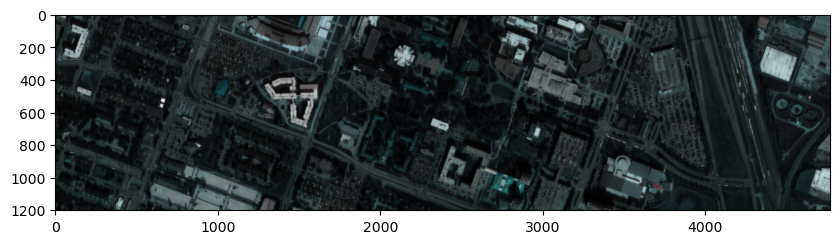

In [5]:
# Bands selected
# nbands=[35,20,5]
nbands=[10,21,22]

plt.figure(figsize=(10,15))
plt.imshow(hyp[:,:,nbands])
plt.show()

L'image `label` donne pour chaque pixel de l'image une information sur la classe du pixel avec la nomenclature suivante:
0 – inconnu (à ne pas utiliser !)
1 – Herbes saines
2 – Herbes en état de stress hydrique
3 – Conifères
4 - Feuillus
5 – Bâtiments résidentiels
6 – Bâtiments non-résidentiels
7 – Routes
8 – Trottoirs
9 – Carrefour
10 – Grands axes routiers
11 – Stationnements asphaltés
12 – Voitures

La fonction suivante permet de visualiser cette image. Les pixels blancs indiquent les endroits où les étiquettes ne sont pas disponibles, qui correspondent à la **classe 0**.

In [6]:
def viz_label_img(label_img):
    N = len(np.bincount(label_img.flatten())) # nombre d'étiquettes uniques
    colours = cm.get_cmap("tab10",N)
    cmap = colours(np.linspace(0, 1, N))  # obtenir une image RGB
    cmap[0,-1] = 0  # transparent pour les pixels à étiquetter
    display_img = cmap[label_img.flatten()]
    display_img = display_img.reshape((label_img.shape[0], label_img.shape[1], -1))
    return display_img

In [7]:
np.where(label != 0)
print(label[np.where(label != 0)])

[12 12 12 ...  6  6  6]


In [8]:
np.bincount(label.flatten())

array([4973752,   11820,   28180,   35779,   13367,   34125,  413636,
         55268,   86094,    3085,   50607,   15247,   10176], dtype=int64)

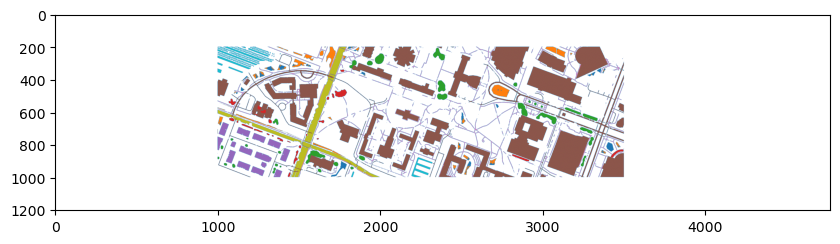

In [9]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(label))
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
(1202, 4768)
(920, 1500)


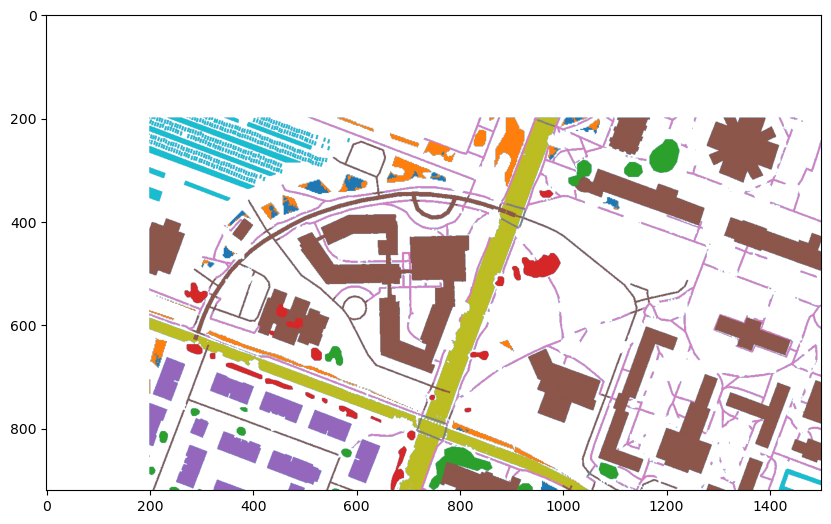

In [10]:
window = label[:920, 800:2300]
print(np.unique(label.flatten()))
print(np.unique(window.flatten()))
print(label.shape)
print(window.shape)
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(window))
plt.show()

In [11]:
print(label[np.where(label != 0)])


[12 12 12 ...  6  6  6]


## Objectif du challenge

Sur la visualisation précédente, vous voyez beaucoup de pixels blancs pour laquelle la classe n'est pas connue. 

Votre **objectif** est d'obtenir la classe de tous les pixels de l'image `img` avec une méthode aussi **précise** que possible. 

L'évaluation prendra en compte les éléments suivants:
1. La qualité du protocole expérimental mis en place, et sa **justification**
2. Les éventuels pré-traitement utilisés
3. Les méthodes de classification utilisées (toutes les méthodes implémentées par scikit-learn peuvent être utilisées, même celles que nous n'avons pas vu en cours)
4. La recherche d'une solution aussi précise que possible et le choix des métriques utilisées

## Rendu

1. Code

Vous crééerez un projet GIT sous https://forgens.univ-ubs.fr/gitlab/ auquel j'aurais accès. 
Ce projet doit contenir tous vos développements en Python sous forme de notebooks ou scripts.

2. Meilleures prédictions

Sous Moodle, un.e membre du groupe remettra un fichier `.npy` dont la structure est équivalente à celle de `label` mais où chaque pixel a une valeur de 1 à 12 (pas de 0) représentant une des classes à prédire.

## Préparation des données

In [12]:
X = hyp[label != 0]
X_nb_pixel = X.shape[0];
X_depth = X.shape[1];
X_nb_values = X_nb_pixel *  X_depth;

y = label[label != 0]
y_nb_pixel = y.shape[0]

## Découpage des données en données d'apprentissage et de test.

Pour entraîner le modèle, il est nécessaire de séparer notre dataset en deux groupes distincts : les données d'apprentissage et les données de tests. Ceci doit être plusieurs fois avec plusieurs facon de regroupement différement afin que le modèle généralise bien. L'objectif est donc de trouver des splits qui permettent d'avoir chaque classe dans les datasets d'apprentissage et de test de manière équitable.

On peut pour cela utiliser ShuffleSplit:

In [13]:
from sklearn.model_selection import ShuffleSplit

cvShuffleSplit = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)

Explications des hyperparamètres :
1. nb_splits = 40 => Nombre de split. Le modèle sera donc entrainer 40 fois sur 40 répartitions des données différentes
2. test_size = 0.3 => Pourcentage de la taille de l'ensemble de test sur la taille totale, soit 30%.
3. random_state=0

On peut aussi utiliser KFold avec shuffle=True

In [14]:
from sklearn.model_selection import KFold
cvKFold = KFold(n_splits=3, shuffle=True, random_state=0)

Ou bien StratifiedKFold

In [15]:
from sklearn.model_selection import StratifiedKFold

cvSKFold = StratifiedKFold(n_splits=3, shuffle=True)

L'objectif est aussi d'avoir, pour le dataset d'apprentissage et de test, des occurrences de classes équitablement réparties. En effet, il faut que le modèle soit en capacité de reconnaitre chaque classe et de les utiliser pour classifier. Regardons la répartitions des classes dans "label" (hormis la classe zéro) :

In [16]:
classes, occurrences = np.unique(y, return_counts=True)

for classe, occurrence in zip(classes, occurrences):
    repartition = round((occurrence*100)/y_nb_pixel, 2);
    print(f"La classe {classe} apparaît {occurrence} fois ({repartition} % de l'image classifiée)")

La classe 1 apparaît 11820 fois (1.56 % de l'image classifiée)
La classe 2 apparaît 28180 fois (3.72 % de l'image classifiée)
La classe 3 apparaît 35779 fois (4.72 % de l'image classifiée)
La classe 4 apparaît 13367 fois (1.76 % de l'image classifiée)
La classe 5 apparaît 34125 fois (4.51 % de l'image classifiée)
La classe 6 apparaît 413636 fois (54.61 % de l'image classifiée)
La classe 7 apparaît 55268 fois (7.3 % de l'image classifiée)
La classe 8 apparaît 86094 fois (11.37 % de l'image classifiée)
La classe 9 apparaît 3085 fois (0.41 % de l'image classifiée)
La classe 10 apparaît 50607 fois (6.68 % de l'image classifiée)
La classe 11 apparaît 15247 fois (2.01 % de l'image classifiée)
La classe 12 apparaît 10176 fois (1.34 % de l'image classifiée)


On observe que la classe 6 est celle qui apparait le plus de fois dans les pixels labelisés (54.61% de l'image classifiée). 
À l'inverse, la classe 9 est celle qui apparait le moins parmis les pixels lablisés (0.41% de l'image classifiée).

## Train data

In [17]:
X = hyp[label != 0]
y = label[label != 0]

print(hyp.shape)
challenge_X = hyp.reshape((-1,48))

(1202, 4768, 48)


## Generate nested cross validation model

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

def gen_nested_cross_validate(model, X, y, param_grid, n_splits, n_cv):
    cv = StratifiedKFold(n_splits=n_splits)
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=cv)
    return cross_validate(grid_search, X, y, return_estimator=True, cv=n_cv)

## Modèle DummyClassifier

In [19]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')

## Modèle LogisticRegression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


log_reg_clf = LogisticRegression()
pipe = make_pipeline(StandardScaler(), LogisticRegression(solver="sag"))


In [21]:
# _ = pipe.fit(train_X[:, :5], train_y)
_ = pipe.fit(X, y)

C:\Users\Sylvain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [22]:
# log_reg_predict = pipe.predict(challenge_X[:, :5])
log_reg_predict = pipe.predict(challenge_X)

## Modèle DecisionTree

In [23]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()

In [24]:
_ = tree_clf.fit(X, y)

In [25]:
tree_predict = tree_clf.predict(challenge_X)

## Modèle RandomForest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# TODO: add min samples leaf
r_forest_clf = RandomForestClassifier(random_state=0, n_jobs=-1)

params_grid = {
    "n_estimators": [150],
    "max_depth": [None],
    "min_samples_leaf": [1, 10]
}

r_forest_cv_result = gen_nested_cross_validate(r_forest_clf, X, y, params_grid, 5, 3)

In [27]:
print(r_forest_cv_result)
print("1", r_forest_cv_result["estimator"][0].best_params_)
print("2", r_forest_cv_result["estimator"][1].best_params_)
print("3", r_forest_cv_result["estimator"][2].best_params_)

{'fit_time': array([278.32922435, 281.96184063, 274.01299453]), 'score_time': array([2.0619967 , 2.1780026 , 2.05400014]), 'estimator': [GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [None], 'min_samples_leaf': [1, 10],
                         'n_estimators': [150]}), GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [None], 'min_samples_leaf': [1, 10],
                         'n_estimators': [150]}), GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [None], 'min_samples_leaf': [1, 10],
       

In [28]:
ss_r_forest_clf = cross_validate(r_forest_clf, X, y, cv=cvShuffleSplit)
ss_test_score = ss_r_forest_clf["test_score"]
print(f"The average accuracy is "
      f"{ss_test_score.mean():.3f} ± {ss_test_score.std():.3f}")

The average accuracy is 0.986 ± 0.000


In [29]:
ss_r_forest_clf = cross_validate(r_forest_clf, X, y, cv=cvShuffleSplit, scoring="f1_weighted")
ss_test_score = ss_r_forest_clf["test_score"]
print(f"The average accuracy is "
      f"{ss_test_score.mean():.3f} ± {ss_test_score.std():.3f}")

The average accuracy is 0.986 ± 0.000


In [30]:
#_ = r_forest_clf.fit(train_X, train_y)
#Using Stratif. KFold
skfold_r_forest_clf = cross_validate(r_forest_clf, X, y, cv=cvSKFold)
skfold_test_score = skfold_r_forest_clf["test_score"]
print(f"The average accuracy is "
      f"{skfold_test_score.mean():.3f} ± {skfold_test_score.std():.3f}")

The average accuracy is 0.984 ± 0.000


In [31]:
#forest_predict = cv_r_forest_clf.predict(challenge_X)

## Modèle HistGradientBoostingClassifier

In [32]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gradient_boost_clf = HistGradientBoostingClassifier(max_iter=35, random_state=0, n_iter_no_change=3)

In [33]:
_ = hist_gradient_boost_clf.fit(X, y)

In [34]:
hist_grad_boost_predict = hist_gradient_boost_clf.predict(challenge_X)

# Some metrics

In [35]:
forest_first_estimator = r_forest_cv_result["estimator"][0]
forest_first_estimator.fit(X, y)
forest_predict = forest_first_estimator.predict(challenge_X)

In [42]:
"""
classifiers = ss_r_forest_clf["estimator"]
#forest_ss_clf_estimator = classifiers[0]
#forest_ss_clf_estimator = ss_r_forest_clf.estimators_[0]
forest_ss_clf_estimator.fit(X,y)
forest_ss_clf_predict = forest_ss_clf_estimator.predict(challenge_X)
"""

'\nclassifiers = ss_r_forest_clf["estimator"]\n#forest_ss_clf_estimator = classifiers[0]\n#forest_ss_clf_estimator = ss_r_forest_clf.estimators_[0]\nforest_ss_clf_estimator.fit(X,y)\nforest_ss_clf_predict = forest_ss_clf_estimator.predict(challenge_X)\n'

In [44]:
"""
forest_skfold_estimator = skfold_r_forest_clf["estimator"][0]
forest_skfold_estimator.fit(X,y)
forest_skfold_predict = forest_skfold_estimator.predict(challenge_X)
"""

'\nforest_skfold_estimator = skfold_r_forest_clf["estimator"][0]\nforest_skfold_estimator.fit(X,y)\nforest_skfold_predict = forest_skfold_estimator.predict(challenge_X)\n'

In [46]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix


dummy.fit(X, y)
dum_predict = dummy.predict(challenge_X)

dum_predict_reshape = dum_predict.reshape(label.shape)
log_reg_predict_reshape = log_reg_predict.reshape(label.shape)
tree_predict_reshape = tree_predict.reshape(label.shape)
hist_grad_boost_predict_reshape = hist_grad_boost_predict.reshape(label.shape)


forest_predict_reshape = forest_predict.reshape(label.shape)
#forest_predict_ss_clf_reshape = forest_ss_clf_predict.reshape(label.shape)
#forest_predict_skfold_reshape = forest_skfold_predict.reshape(label.shape)




y_true = label[label != 0]

y_pred_dummy = dum_predict_reshape[label != 0]
y_pred_log_reg = log_reg_predict_reshape[label != 0]
y_pred_tree = tree_predict_reshape[label != 0]
y_pred_hist = hist_grad_boost_predict_reshape[label != 0]
y_pred_forest_first = forest_predict_reshape[label != 0]
#y_pred_forest_ss_clf = forest_predict_ss_clf_reshape[label != 0]
#y_pred_forest_skfold = forest_predict_skfold_reshape[label != 0]


In [47]:
#R2 Score

dummy_score = r2_score(y_true, y_pred_dummy)
pred_log_reg_score = r2_score(y_true, y_pred_log_reg)
tree_score = r2_score(y_true, y_pred_tree)
forest_score = r2_score(y_true, y_pred_forest_first)

#forest_ss_clf_score = r2_score(y_true, y_pred_forest_ss_clf)
#forest_skfold_score = r2_score(y_true, y_pred_forest_skfold)


hist_score = r2_score(y_true, y_pred_hist)

print("Dummy score r2 : ", dummy_score)
print("Logistic Regression score r2 : ", pred_log_reg_score)
print("Tree score r2 : ", tree_score)
print("Forest score r2 : ", forest_score)

#print("Forest SS CLF score r2 : ", forest_ss_clf_score)
#print("Forest skFold score r2 : ", forest_skfold_score)

print("Hist score r2 : ", hist_score)

Dummy score r2 :  -0.02406256429886433
Logistic Regression score r2 :  0.5163208831672925
Tree score r2 :  0.9974224118546227
Forest score r2 :  0.997414260089457
Hist score r2 :  0.6463985999155115


In [48]:
#Matrice de confusion

dummy_score = confusion_matrix(y_true, y_pred_dummy, normalize = "true")
pred_log_reg_score = confusion_matrix(y_true, y_pred_log_reg, normalize = "true")
tree_score = confusion_matrix(y_true, y_pred_tree, normalize = "true")
forest_score = confusion_matrix(y_true, y_pred_forest_first, normalize = "true")

#forest_ss_clf_score = confusion_matrix(y_true, y_pred_forest_ss_clf, normalize = "true")
#forest_skfold_score = confusion_matrix(y_true, y_pred_forest_skfold, normalize = "true")

hist_score = confusion_matrix(y_true, y_pred_hist, normalize = "true")

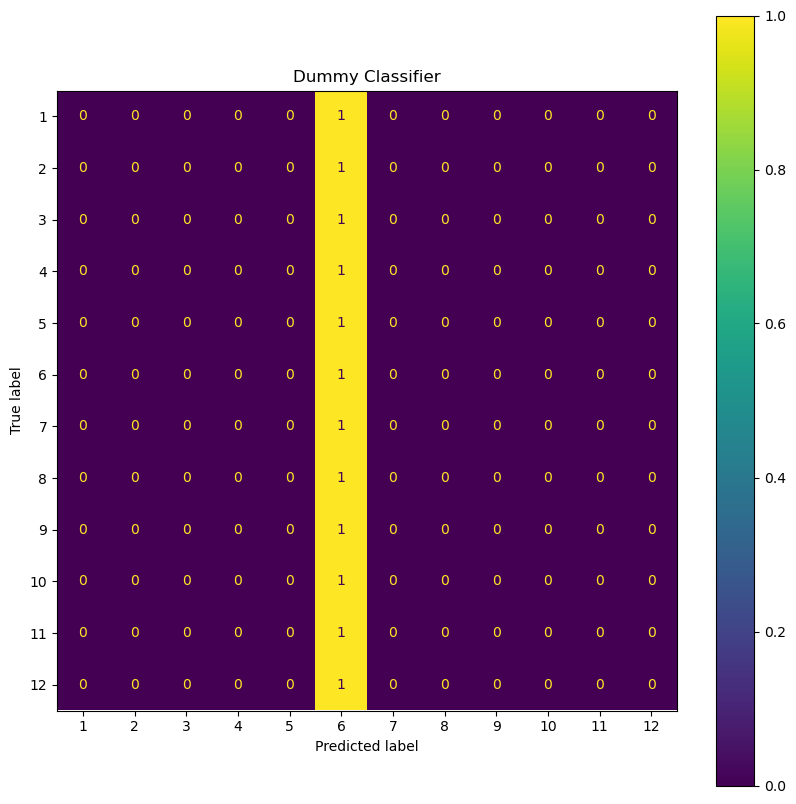

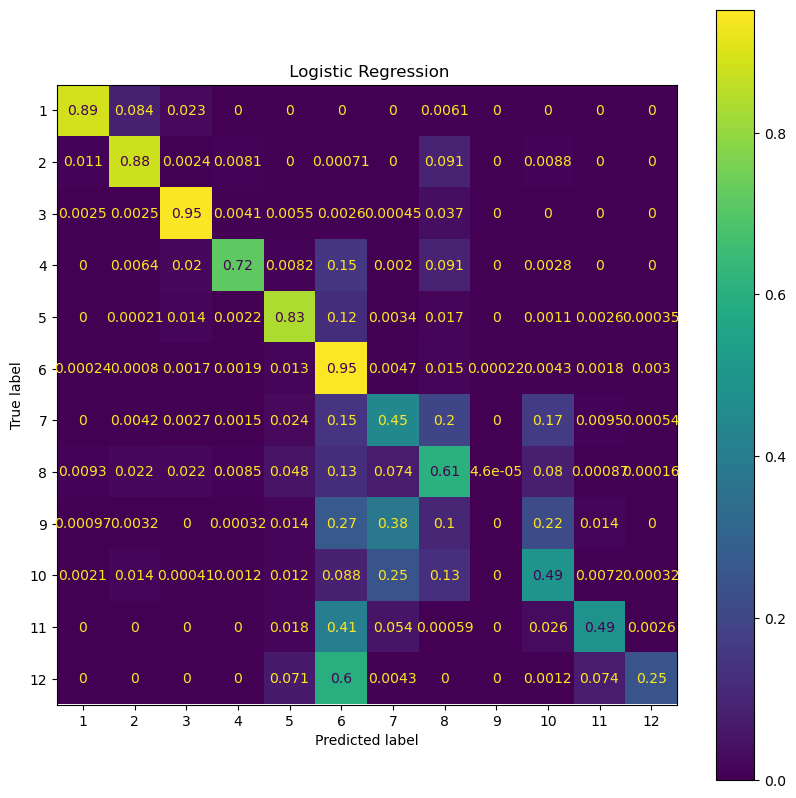

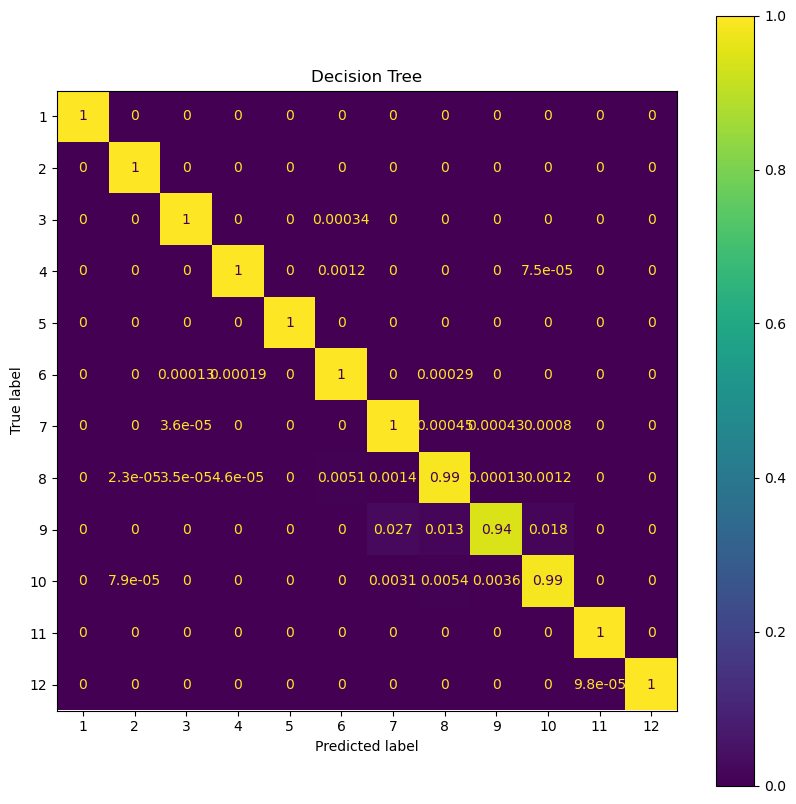

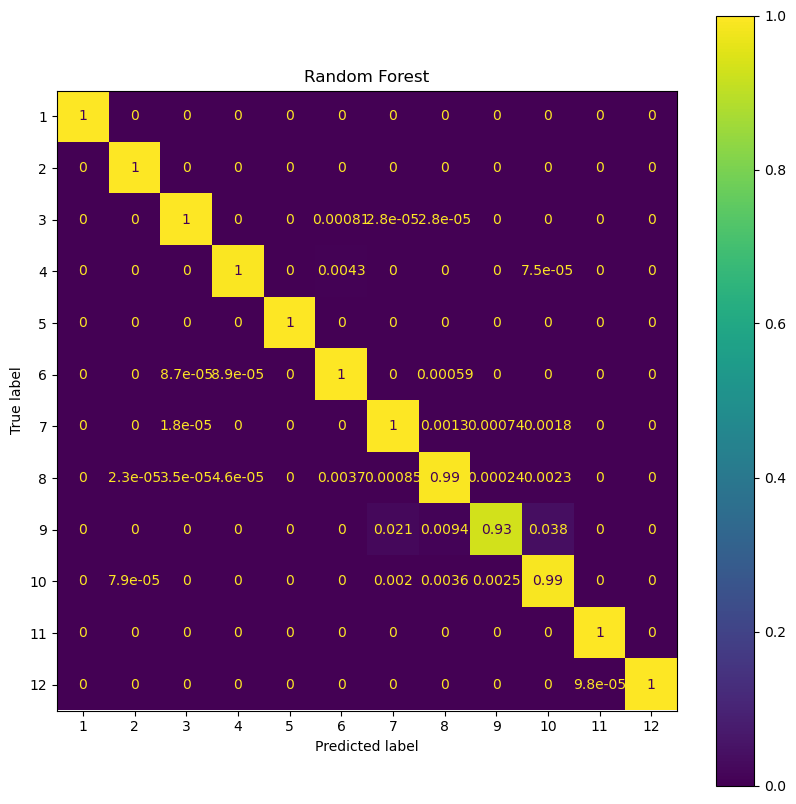

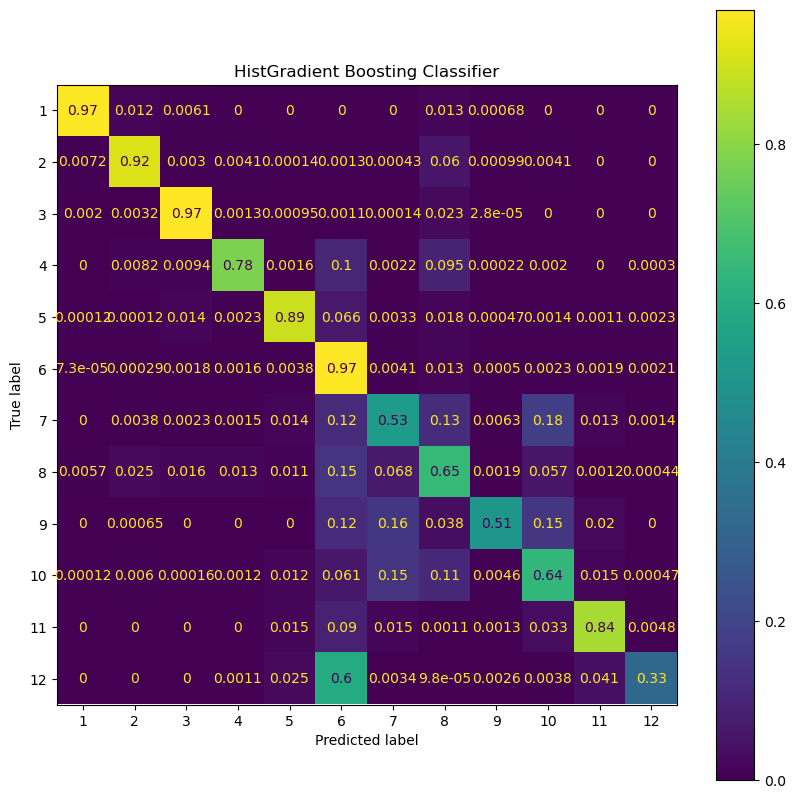

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = [dummy_score, pred_log_reg_score, tree_score, forest_score, hist_score]
#confusion_matrix = [dummy_score, pred_log_reg_score, tree_score, forest_score, forest_ss_clf_score, forest_skfold_score, hist_score]

titles = ["Dummy Classifier", " Logistic Regression", "Decision Tree", "Random Forest", "HistGradient Boosting Classifier"]
#titles = ["Dummy Classifier", " Logistic Regression", "Decision Tree", "Random Forest 1","Random Forest 2", "Random Forest 3", "HistGradient Boosting Classifier"]

for i in range(len(confusion_matrix)):
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix[i], display_labels=classes)
    disp.plot(ax=ax)
    plt.title(titles[i])
    plt.show()


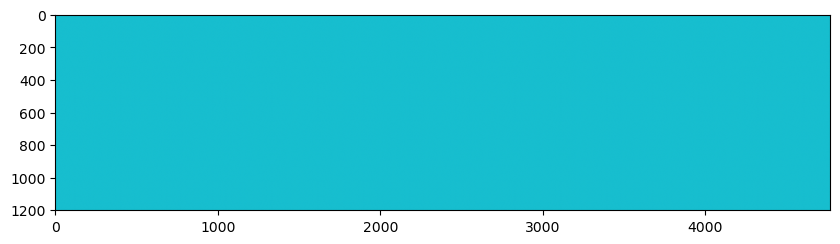

In [51]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(dum_predict_reshape))
plt.show()

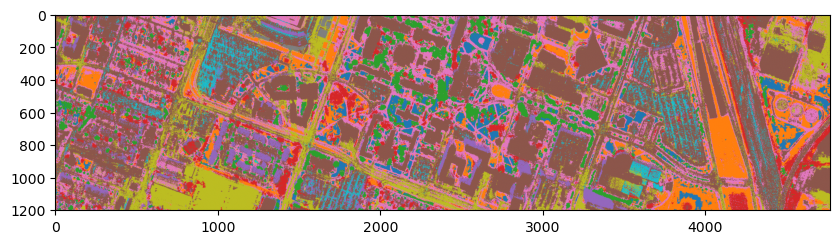

In [52]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(log_reg_predict_reshape))
plt.show()

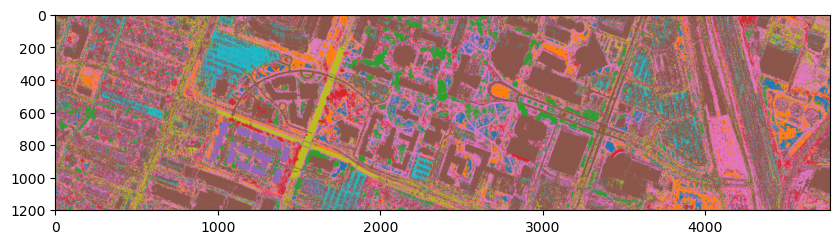

In [53]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(tree_predict_reshape))
plt.show()

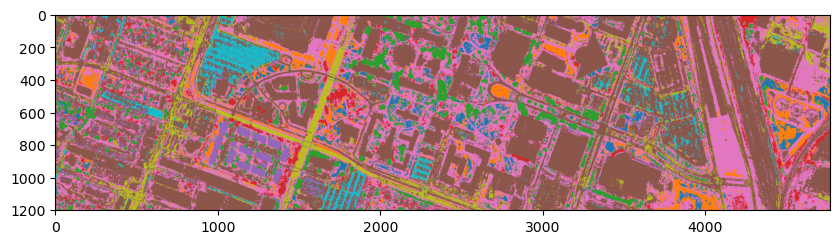

In [54]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(forest_predict_reshape))
plt.show()

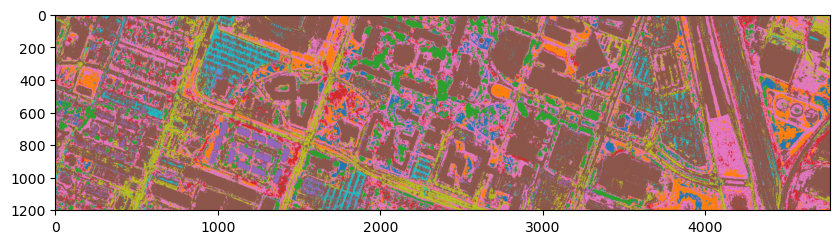

In [55]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(hist_grad_boost_predict_reshape))
plt.show()